In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Sep 11 22:30:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |   1626MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 50

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'GoodVersion_DDplus_iter0_adaptivenet_carefulAdam_80kevents_1'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/DDplus/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from functions.my_training_kde import adaptivetrainNet
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:0"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
from functions.mod_adam import epoch_Reversible_Adam
optimizer = epoch_Reversible_Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

# ## finished at training cost = 1.46, validation cost = 1.50
# d_folder = 'baileyds200ep_DDplus_iter3'
# d_name = d_folder
# suffix = 'final'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

# model.load_state_dict(pretrained_dict,strict=False)

#mine
torch.save(model.state_dict(), output / f'{name}_init.pyt')
param_states.append(get_param_state(model))


output =  baileyds/DDplus/GoodVersion_DDplus_iter0_adaptivenet_carefulAdam_80kevents_1
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
inde

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                               # '/share/lazy/will/data/June30_2020_80k_2.h5',
                                #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                #'/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
        #                  device=device,
                          #slice = slice(None,60000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
  #                          slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 36.35 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.1714 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t.shape =  torch.Size([20000, 9, 600])


<IPython.core.display.Javascript object>


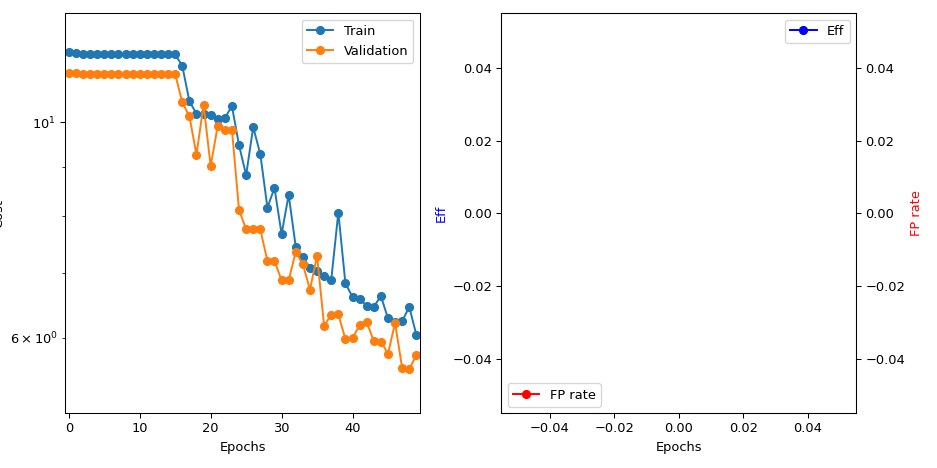

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in adaptivetrainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        loss_increase_limit = 0.02, lr_factor = 0.8, lr_increase_factor = 0.05,
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 5000, val = 1250


Number of batches: train = 5000, val = 1250


new cost: 11.809949467277526 | old cost: 1000000.0
Epoch 0: train=11.8099, val=11.2451, took 344.42 s


new cost: 11.782469511222839 | old cost: 11.809949467277526
num: tensor(99.5351, device='cuda:0')
denom: tensor(526.7256, device='cuda:0')
dot: 0.18896958 | ratio: 1.009448479115963
lr changed to 0.00010094484791159631
Epoch 1: train=11.7825, val=11.2365, took 338.19 s


new cost: 11.773078692436219 | old cost: 11.782469511222839
num: tensor(116.5076, device='cuda:0')
denom: tensor(575.6313, device='cuda:0')
dot: 0.20239963 | ratio: 1.0101199813187123
lr changed to 0.00010196640788668191
Epoch 2: train=11.7731, val=11.2302, took 340.1 s


new cost: 11.769299296855927 | old cost: 11.773078692436219
num: tensor(96.1555, device='cuda:0')
denom: tensor(554.6117, device='cuda:0')
dot: 0.17337449 | ratio: 1.0086687244474888
lr changed to 0.0001028503265795518
Epoch 3: train=11.7693, val=11.2278, took 341.62 s


new cost: 11.767312387561798 | old cost: 11.769299296855927
num: tensor(75.8993, device='cuda:0')
denom: tensor(527.4588, device='cuda:0')
dot: 0.1438961 | ratio: 1.0071948051452637
lr changed to 0.00010359031463841842
Epoch 4: train=11.7673, val=11.2263, took 339.89 s


new cost: 11.76579229402542 | old cost: 11.767312387561798
num: tensor(64.4190, device='cuda:0')
denom: tensor(521.9136, device='cuda:0')
dot: 0.12342855 | ratio: 1.006171427667141
lr changed to 0.0001042296147722258
Epoch 5: train=11.7658, val=11.225, took 336.46 s


new cost: 11.764251439857484 | old cost: 11.76579229402542
num: tensor(60.5003, device='cuda:0')
denom: tensor(517.8370, device='cuda:0')
dot: 0.11683267 | ratio: 1.0058416336774827
lr changed to 0.00010483848600007028
Epoch 6: train=11.7643, val=11.2243, took 341.77 s


new cost: 11.763118239116668 | old cost: 11.764251439857484
num: tensor(62.1094, device='cuda:0')
denom: tensor(519.0879, device='cuda:0')
dot: 0.11965109 | ratio: 1.0059825543314218
lr changed to 0.0001054656879385897
Epoch 7: train=11.7631, val=11.2228, took 338.95 s


new cost: 11.761877855300904 | old cost: 11.763118239116668
num: tensor(62.1233, device='cuda:0')
denom: tensor(521.2243, device='cuda:0')
dot: 0.1191873 | ratio: 1.005959365144372
lr changed to 0.00010609419648321814
Epoch 8: train=11.7619, val=11.2226, took 338.8 s


new cost: 11.760662746334075 | old cost: 11.761877855300904
num: tensor(64.4509, device='cuda:0')
denom: tensor(522.0928, device='cuda:0')
dot: 0.12344714 | ratio: 1.0061723571270704
lr changed to 0.00010674904775302215
Epoch 9: train=11.7607, val=11.223, took 345.66 s


new cost: 11.759702711009979 | old cost: 11.760662746334075
num: tensor(65.0223, device='cuda:0')
denom: tensor(520.7412, device='cuda:0')
dot: 0.124864936 | ratio: 1.006243246793747
lr changed to 0.00010741550840314174
Epoch 10: train=11.7597, val=11.2214, took 337.71 s


new cost: 11.75868602180481 | old cost: 11.759702711009979
num: tensor(63.4429, device='cuda:0')
denom: tensor(517.7814, device='cuda:0')
dot: 0.122528344 | ratio: 1.006126417219639
lr changed to 0.00010807358062347902
Epoch 11: train=11.7587, val=11.2224, took 341.31 s


new cost: 11.7581332072258 | old cost: 11.75868602180481
num: tensor(63.4492, device='cuda:0')
denom: tensor(515.1995, device='cuda:0')
dot: 0.12315457 | ratio: 1.0061577286571264
lr changed to 0.00010873906840796247
Epoch 12: train=11.7581, val=11.2236, took 340.71 s


new cost: 11.75690751543045 | old cost: 11.7581332072258
num: tensor(63.0374, device='cuda:0')
denom: tensor(511.6618, device='cuda:0')
dot: 0.12320134 | ratio: 1.0061600670218467
lr changed to 0.00010940890835724869
Epoch 13: train=11.7569, val=11.2213, took 516.12 s


new cost: 11.756271164798736 | old cost: 11.75690751543045
num: tensor(61.7909, device='cuda:0')
denom: tensor(515.3953, device='cuda:0')
dot: 0.11989036 | ratio: 1.0059945181012153
lr changed to 0.00011006476203883043
Epoch 14: train=11.7563, val=11.2246, took 519.28 s


new cost: 11.752698897838593 | old cost: 11.756271164798736
num: tensor(67.3277, device='cuda:0')
denom: tensor(539.4310, device='cuda:0')
dot: 0.1248125 | ratio: 1.006240624934435
lr changed to 0.0001107516349372126
Epoch 15: train=11.7527, val=11.217, took 514.88 s


new cost: 11.44010700378418 | old cost: 11.752698897838593
num: tensor(59.2925, device='cuda:0')
denom: tensor(1054.5084, device='cuda:0')
dot: 0.056227654 | ratio: 1.0028113827109337
lr changed to 0.00011106300016888272
Epoch 16: train=11.4401, val=10.4883, took 520.38 s


new cost: 10.521161448287964 | old cost: 11.44010700378418
num: tensor(191.4177, device='cuda:0')
denom: tensor(1866.0930, device='cuda:0')
dot: 0.1025767 | ratio: 1.0051288351416587
lr changed to 0.00011163262398708694
Epoch 17: train=10.5212, val=10.1517, took 518.3 s


new cost: 10.209117495250702 | old cost: 10.521161448287964
num: tensor(355.5246, device='cuda:0')
denom: tensor(1367.2533, device='cuda:0')
dot: 0.2600283 | ratio: 1.0130014151334763
lr changed to 0.00011308400607398232
Epoch 18: train=10.2091, val=9.26219, took 521.77 s


new cost: 10.205205464935302 | old cost: 10.209117495250702
num: tensor(193.9298, device='cuda:0')
denom: tensor(1204.2587, device='cuda:0')
dot: 0.1610367 | ratio: 1.008051835000515
lr changed to 0.00011399453983208726
Epoch 19: train=10.2052, val=10.4359, took 524.47 s


new cost: 10.178216012096405 | old cost: 10.205205464935302
num: tensor(154.5869, device='cuda:0')
denom: tensor(1270.0491, device='cuda:0')
dot: 0.12171729 | ratio: 1.0060858644545079
lr changed to 0.00011468829515005934
Epoch 20: train=10.1782, val=9.01471, took 528.94 s


new cost: 10.084574414443969 | old cost: 10.178216012096405
num: tensor(194.2941, device='cuda:0')
denom: tensor(1045.3699, device='cuda:0')
dot: 0.18586162 | ratio: 1.0092930808663367
lr changed to 0.00011575410275131114
Epoch 21: train=10.0846, val=9.92591, took 524.62 s


new cost: 10.105578304958344 | old cost: 10.084574414443969
num: tensor(91.2449, device='cuda:0')
denom: tensor(981.4113, device='cuda:0')
dot: 0.092973135 | ratio: 1.004648656770587
lr changed to 0.00011629220384478925
Epoch 22: train=10.1056, val=9.83088, took 524.03 s


new cost: 10.395664696502685 | old cost: 10.105578304958344
loss increase too large; model backstepping
lr changed to 9.30337630758314e-05
num: tensor(97.1948, device='cuda:0')
denom: tensor(1058.2502, device='cuda:0')
dot: 0.09184483 | ratio: 1.004592241346836
lr changed to 9.346099656927998e-05
Epoch 23: train=10.3957, val=9.83002, took 523.2 s


new cost: 9.47627566614151 | old cost: 10.105578304958344
num: tensor(-32.6245, device='cuda:0')
denom: tensor(928.7093, device='cuda:0')
dot: -0.035128836 | ratio: 0.9982435582205653
lr changed to 9.329683777015809e-05
Epoch 24: train=9.47628, val=8.126, took 521.4 s


new cost: 8.823176867675782 | old cost: 9.47627566614151
num: tensor(218.4469, device='cuda:0')
denom: tensor(685.4622, device='cuda:0')
dot: 0.31868565 | ratio: 1.015934282541275
lr changed to 9.478345594339528e-05
Epoch 25: train=8.82318, val=7.75862, took 528.15 s


new cost: 9.887259478092194 | old cost: 8.823176867675782
loss increase too large; model backstepping
lr changed to 7.582676475471623e-05
num: tensor(36.2886, device='cuda:0')
denom: tensor(799.6030, device='cuda:0')
dot: 0.045383215 | ratio: 1.002269160747528
lr changed to 7.599882787290968e-05
Epoch 26: train=9.88726, val=7.75532, took 524.95 s


new cost: 9.278531209564209 | old cost: 8.823176867675782
loss increase too large; model backstepping
lr changed to 6.079906229832775e-05
num: tensor(82.1231, device='cuda:0')
denom: tensor(917.0190, device='cuda:0')
dot: 0.08955444 | ratio: 1.004477721825242
lr changed to 6.107130358653522e-05
Epoch 27: train=9.27853, val=7.75616, took 529.12 s


new cost: 8.170038940620422 | old cost: 8.823176867675782
num: tensor(3.3177, device='cuda:0')
denom: tensor(477.7055, device='cuda:0')
dot: 0.006944971 | ratio: 1.000347248557955
lr changed to 6.109251050863808e-05
Epoch 28: train=8.17004, val=7.19844, took 524.57 s


new cost: 8.559744079446792 | old cost: 8.170038940620422
loss increase too large; model backstepping
lr changed to 4.887400840691047e-05
num: tensor(82.0393, device='cuda:0')
denom: tensor(428.8547, device='cuda:0')
dot: 0.19129854 | ratio: 1.0095649272203446
lr changed to 4.934148474028908e-05
Epoch 29: train=8.55974, val=7.20048, took 520.45 s


new cost: 7.669310981607437 | old cost: 8.170038940620422
num: tensor(86.2926, device='cuda:0')
denom: tensor(344.0195, device='cuda:0')
dot: 0.2508363 | ratio: 1.0125418156385422
lr changed to 4.9960316545233726e-05
Epoch 30: train=7.66931, val=6.87179, took 521.03 s


new cost: 8.422083418130875 | old cost: 7.669310981607437
loss increase too large; model backstepping
lr changed to 3.9968253236186985e-05
num: tensor(47.0577, device='cuda:0')
denom: tensor(262.1725, device='cuda:0')
dot: 0.17949153 | ratio: 1.008974576741457
lr changed to 4.032695139207713e-05
Epoch 31: train=8.42208, val=6.87224, took 518.18 s


new cost: 7.438244449806214 | old cost: 7.669310981607437
num: tensor(46.0119, device='cuda:0')
denom: tensor(205.8032, device='cuda:0')
dot: 0.22357233 | ratio: 1.0111786164343357
lr changed to 4.0777750913655264e-05
Epoch 32: train=7.43824, val=7.35613, took 517.28 s


new cost: 7.257847369861603 | old cost: 7.438244449806214
num: tensor(68.2630, device='cuda:0')
denom: tensor(110.0947, device='cuda:0')
dot: 0.6200391 | ratio: 1.0310019552707672
lr changed to 4.204194092352289e-05
Epoch 33: train=7.25785, val=7.13891, took 513.86 s


new cost: 7.084373677635193 | old cost: 7.257847369861603
num: tensor(64.2217, device='cuda:0')
denom: tensor(103.0740, device='cuda:0')
dot: 0.62306345 | ratio: 1.0311531722545624
lr changed to 4.3351680751029534e-05
Epoch 34: train=7.08437, val=6.72315, took 521.65 s


new cost: 7.029354549598694 | old cost: 7.084373677635193
num: tensor(59.7982, device='cuda:0')
denom: tensor(100.4349, device='cuda:0')
dot: 0.5953923 | ratio: 1.0297696143388748
lr changed to 4.4642243567929704e-05
Epoch 35: train=7.02935, val=7.28375, took 524.16 s


new cost: 6.949056268310547 | old cost: 7.029354549598694
num: tensor(53.8423, device='cuda:0')
denom: tensor(96.5592, device='cuda:0')
dot: 0.5576089 | ratio: 1.0278804451227188
lr changed to 4.588688918988042e-05
Epoch 36: train=6.94906, val=6.16792, took 518.61 s


new cost: 6.880887309837341 | old cost: 6.949056268310547
num: tensor(50.2787, device='cuda:0')
denom: tensor(94.9646, device='cuda:0')
dot: 0.52944714 | ratio: 1.026472356915474
lr changed to 4.7101623298255736e-05
Epoch 37: train=6.88089, val=6.33646, took 531.86 s


new cost: 8.074073570108414 | old cost: 6.880887309837341
loss increase too large; model backstepping
lr changed to 3.768129863860459e-05
num: tensor(15.4475, device='cuda:0')
denom: tensor(196.0259, device='cuda:0')
dot: 0.07880327 | ratio: 1.0039401635527612
lr changed to 3.7829769118121126e-05
Epoch 38: train=8.07407, val=6.33909, took 520.0 s


new cost: 6.822732193756104 | old cost: 6.880887309837341
num: tensor(19.0558, device='cuda:0')
denom: tensor(167.6747, device='cuda:0')
dot: 0.113647364 | ratio: 1.0056823682039977
lr changed to 3.804473179532251e-05
Epoch 39: train=6.82273, val=5.97687, took 524.05 s


new cost: 6.606496761989593 | old cost: 6.822732193756104
num: tensor(32.2138, device='cuda:0')
denom: tensor(65.8985, device='cuda:0')
dot: 0.48884004 | ratio: 1.0244420021772385
lr changed to 3.8974621212696236e-05
Epoch 40: train=6.6065, val=5.98956, took 521.17 s


new cost: 6.568146253538131 | old cost: 6.606496761989593
num: tensor(31.7749, device='cuda:0')
denom: tensor(63.1712, device='cuda:0')
dot: 0.50299567 | ratio: 1.0251497834920884
lr changed to 3.99548244978817e-05
Epoch 41: train=6.56815, val=6.18227, took 517.35 s


new cost: 6.473449905586243 | old cost: 6.568146253538131
num: tensor(31.7076, device='cuda:0')
denom: tensor(64.0008, device='cuda:0')
dot: 0.49542508 | ratio: 1.0247712537646294
lr changed to 4.094455559463996e-05
Epoch 42: train=6.47345, val=6.22453, took 525.75 s


new cost: 6.452973236227035 | old cost: 6.473449905586243
num: tensor(30.8069, device='cuda:0')
denom: tensor(64.8921, device='cuda:0')
dot: 0.47474042 | ratio: 1.023737020790577
lr changed to 4.1916457362050864e-05
Epoch 43: train=6.45297, val=5.9477, took 518.95 s


new cost: 6.622533439779281 | old cost: 6.452973236227035
loss increase too large; model backstepping
lr changed to 3.3533165889640694e-05
num: tensor(28.1411, device='cuda:0')
denom: tensor(65.4988, device='cuda:0')
dot: 0.42964345 | ratio: 1.0214821726083756
lr changed to 3.425353114738725e-05
Epoch 44: train=6.62253, val=5.94208, took 522.5 s


new cost: 6.278866971254349 | old cost: 6.452973236227035
num: tensor(25.7510, device='cuda:0')
denom: tensor(55.8220, device='cuda:0')
dot: 0.4613055 | ratio: 1.0230652749538423
lr changed to 3.504359826144173e-05
Epoch 45: train=6.27887, val=5.77439, took 515.98 s


new cost: 6.221194581890106 | old cost: 6.278866971254349
num: tensor(22.2426, device='cuda:0')
denom: tensor(47.5184, device='cuda:0')
dot: 0.4680834 | ratio: 1.0234041705727577
lr changed to 3.586376461263571e-05
Epoch 46: train=6.22119, val=6.21013, took 520.27 s


new cost: 6.239276248788833 | old cost: 6.221194581890106
num: tensor(21.6320, device='cuda:0')
denom: tensor(47.8684, device='cuda:0')
dot: 0.4519057 | ratio: 1.0225952848792077
lr changed to 3.667411659089906e-05
Epoch 47: train=6.23928, val=5.57916, took 522.24 s


new cost: 6.451485966825485 | old cost: 6.239276248788833
loss increase too large; model backstepping
lr changed to 2.933929327271925e-05
num: tensor(19.6534, device='cuda:0')
denom: tensor(48.7369, device='cuda:0')
dot: 0.40325424 | ratio: 1.0201627120375634
lr changed to 2.9930852994362708e-05
Epoch 48: train=6.45149, val=5.56722, took 527.45 s


new cost: 6.038659155035019 | old cost: 6.239276248788833
num: tensor(18.0390, device='cuda:0')
denom: tensor(41.6533, device='cuda:0')
dot: 0.43307474 | ratio: 1.021653737127781
lr changed to 3.0578967817112894e-05
Epoch 49: train=6.03866, val=5.75112, took 520.49 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


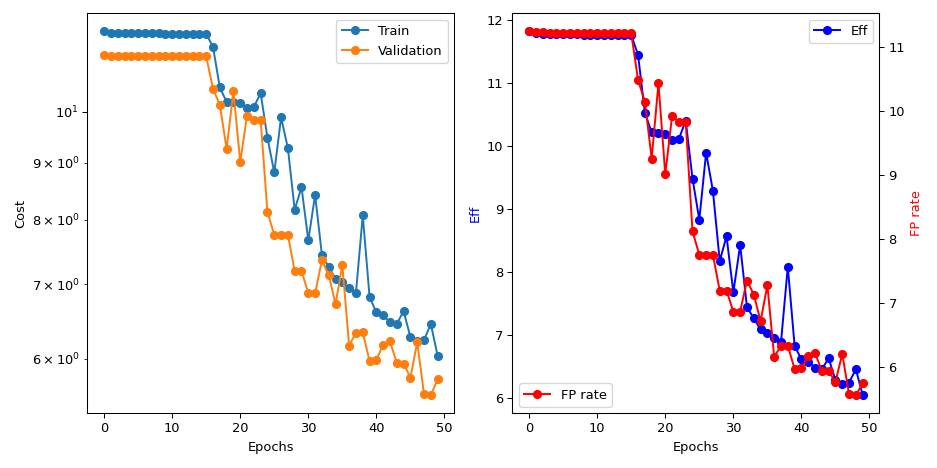

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0


<IPython.core.display.Javascript object>


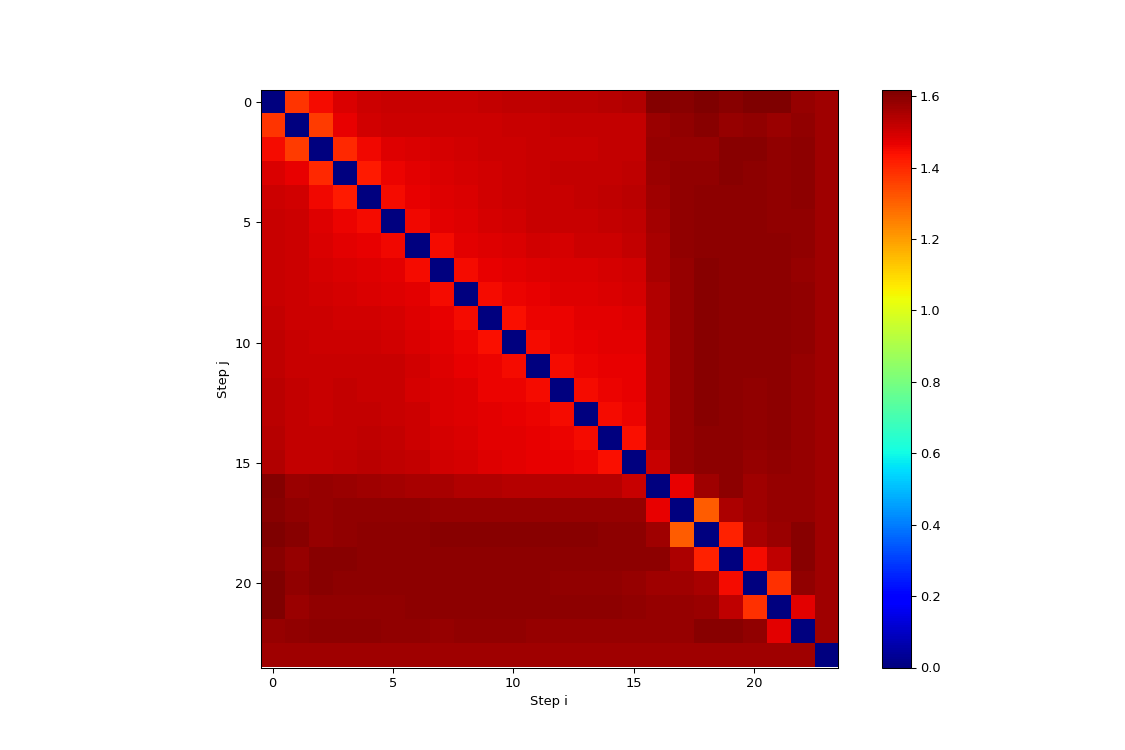

<IPython.core.display.Javascript object>


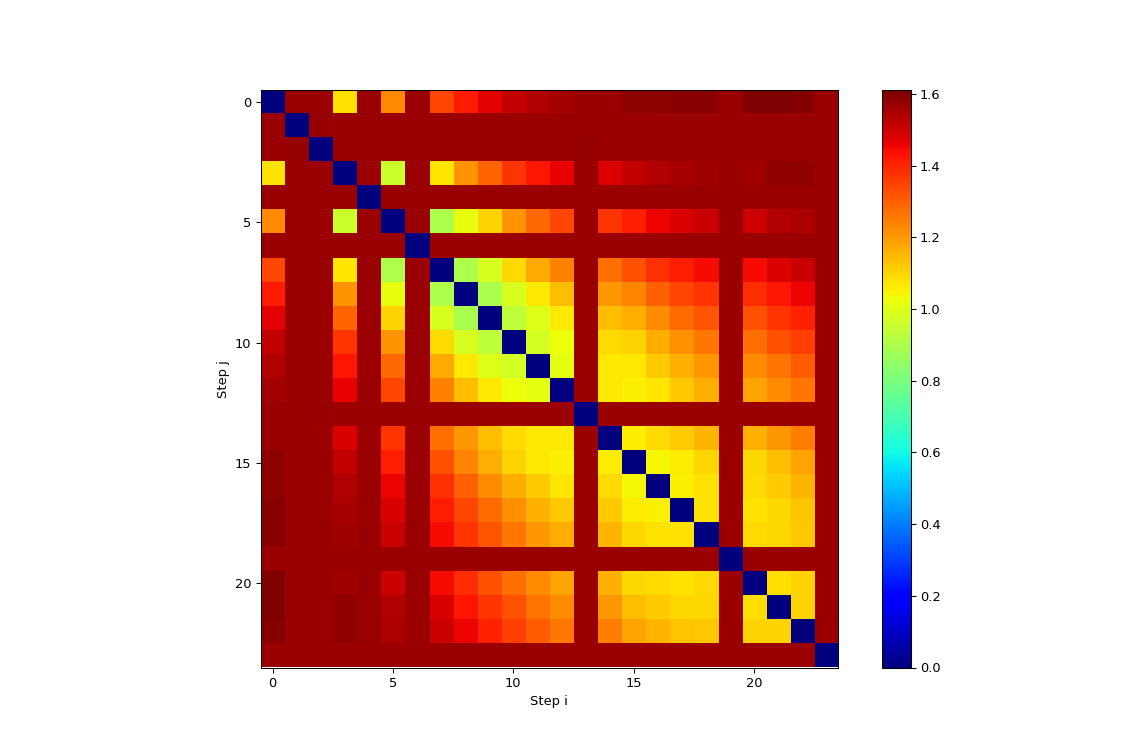

In [22]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [23]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 10, 20, 30, 40]
labels shape: torch.Size([16, 12000])
nEvts: 16 | nFeatures: 4000
y shape: torch.Size([16, 3, 4000])
y shape: torch.Size([16, 4000, 3])


<IPython.core.display.Javascript object>


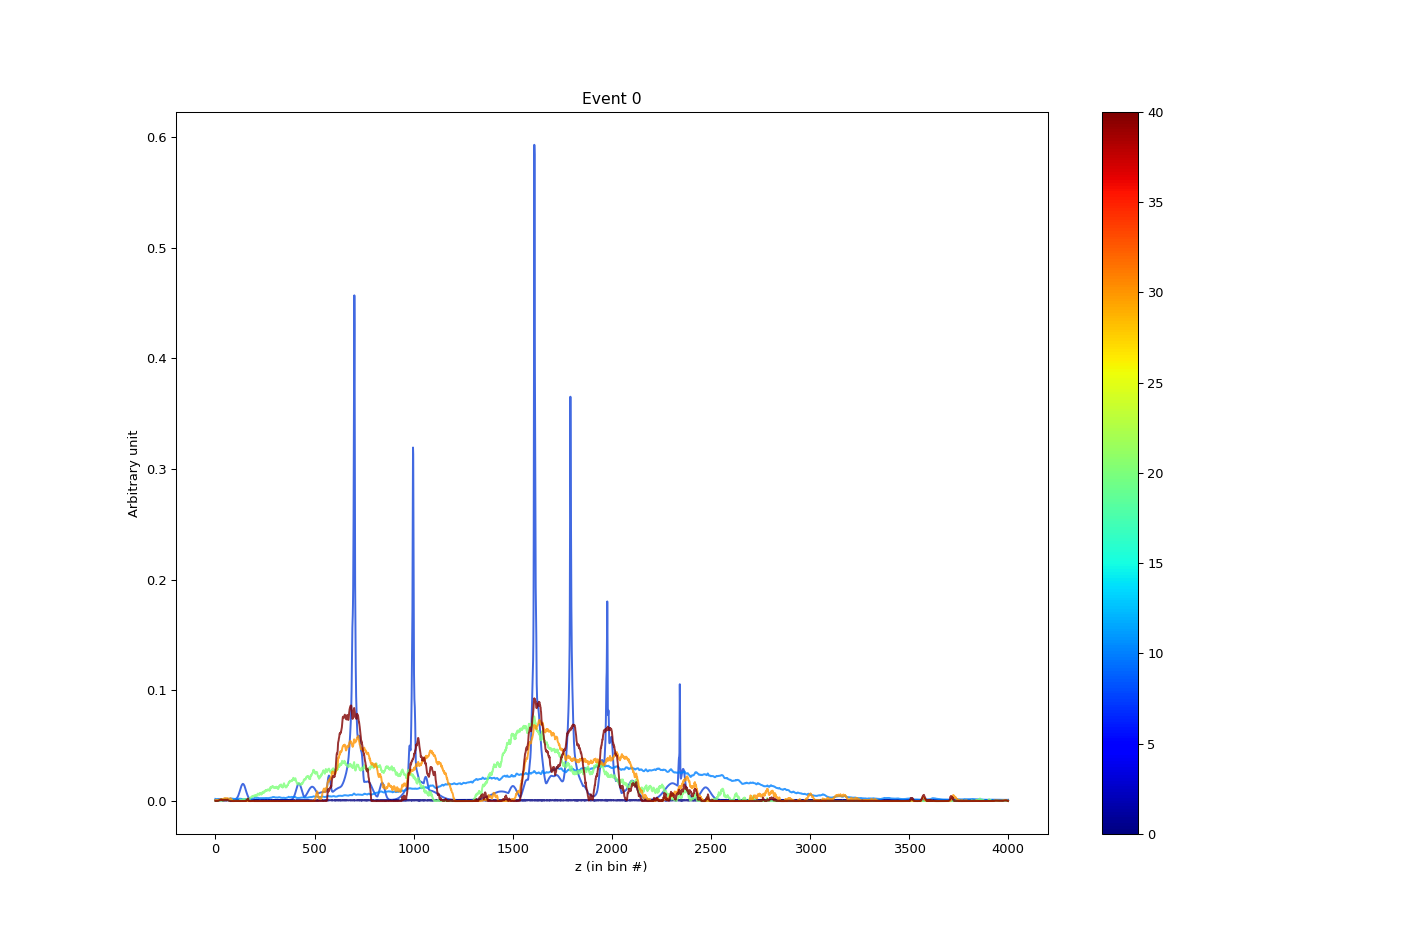

<IPython.core.display.Javascript object>


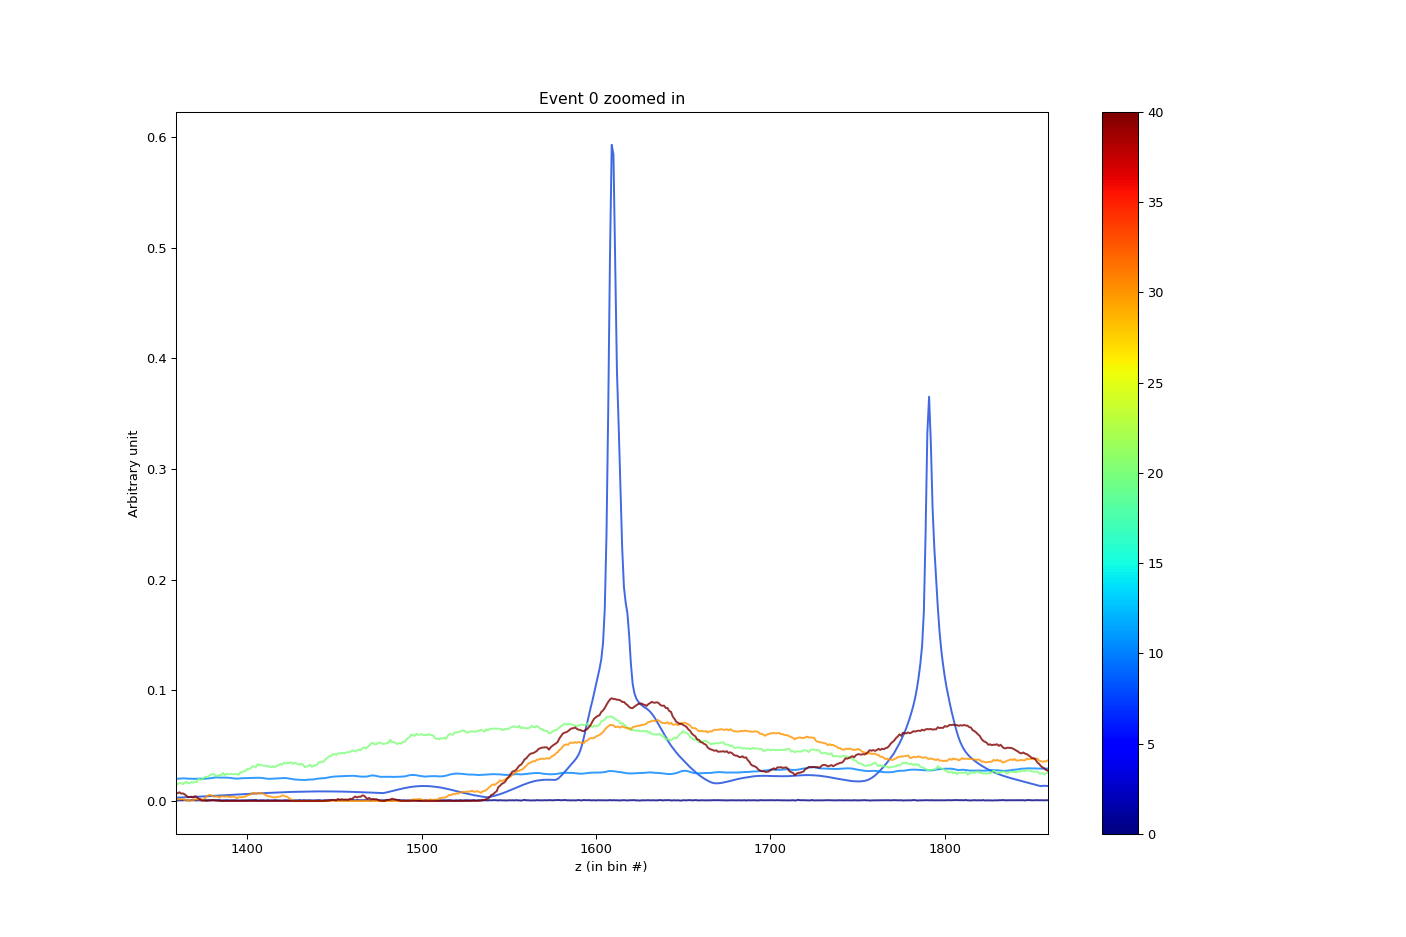

<IPython.core.display.Javascript object>


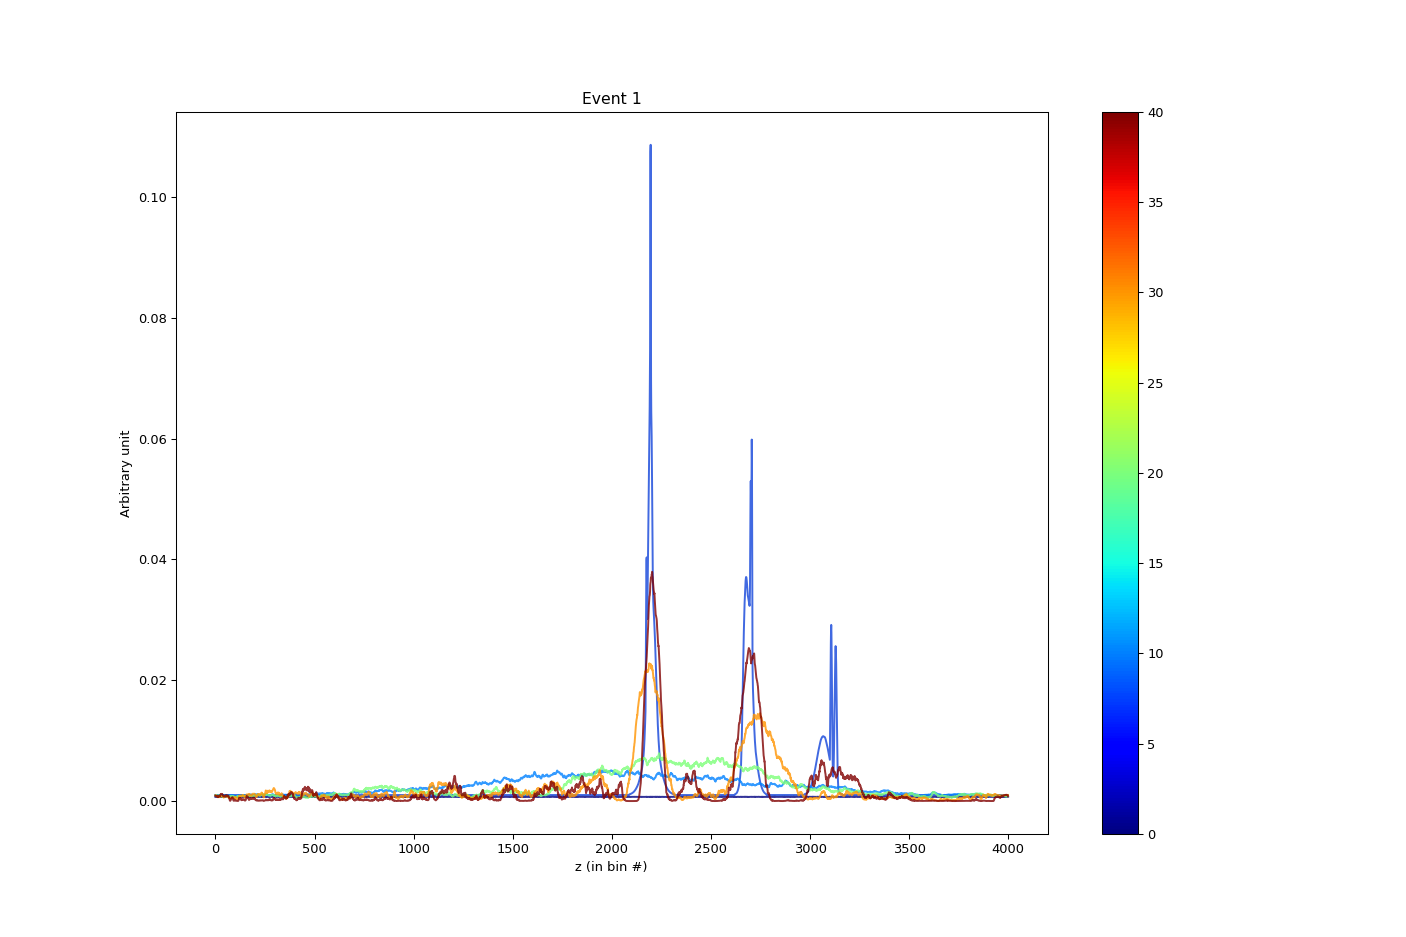

<IPython.core.display.Javascript object>


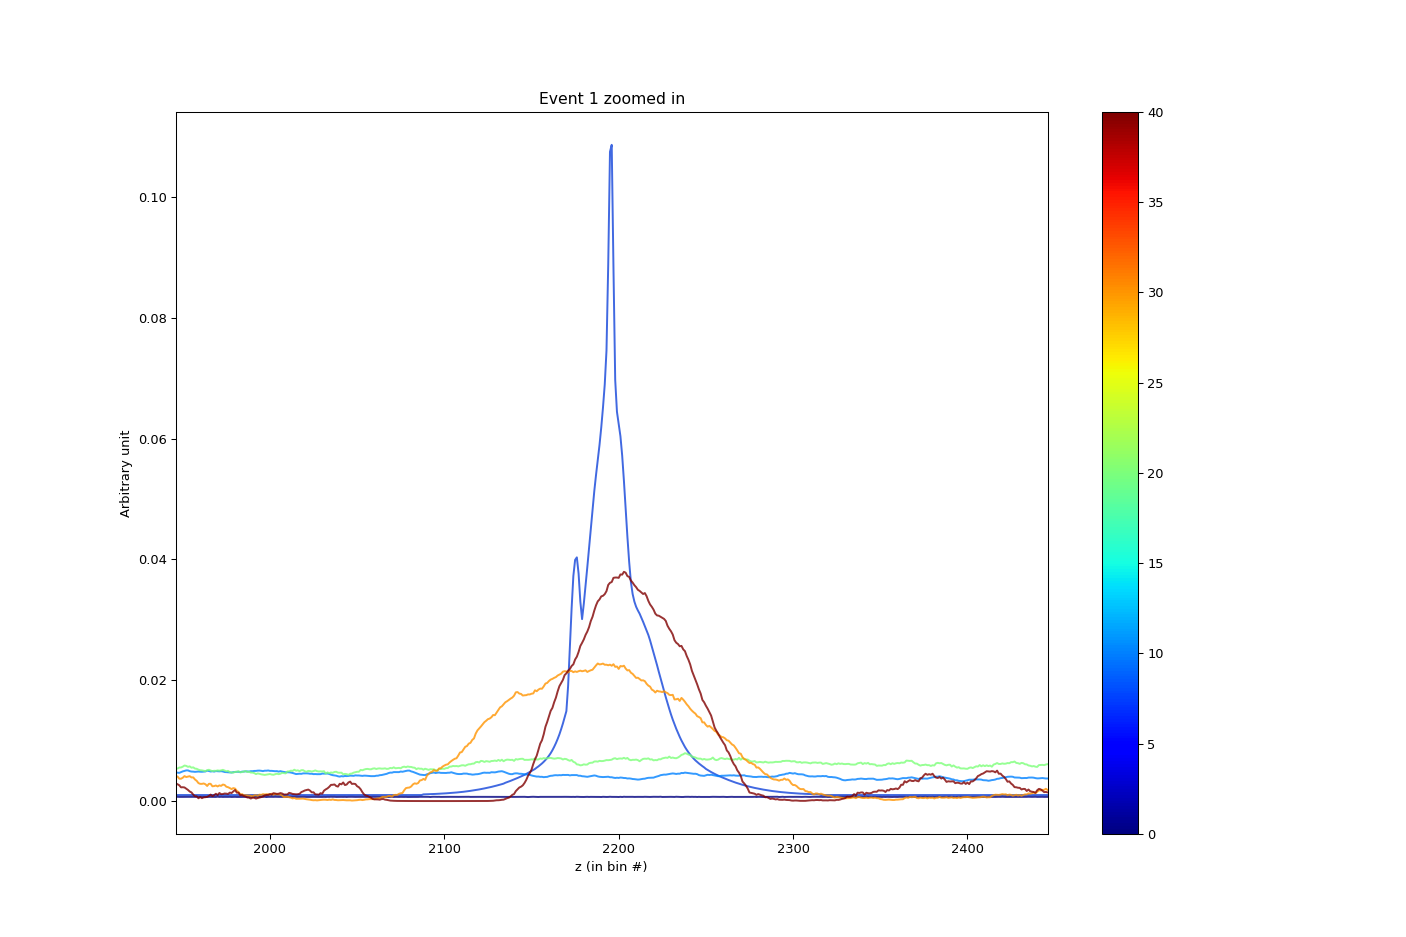

<IPython.core.display.Javascript object>


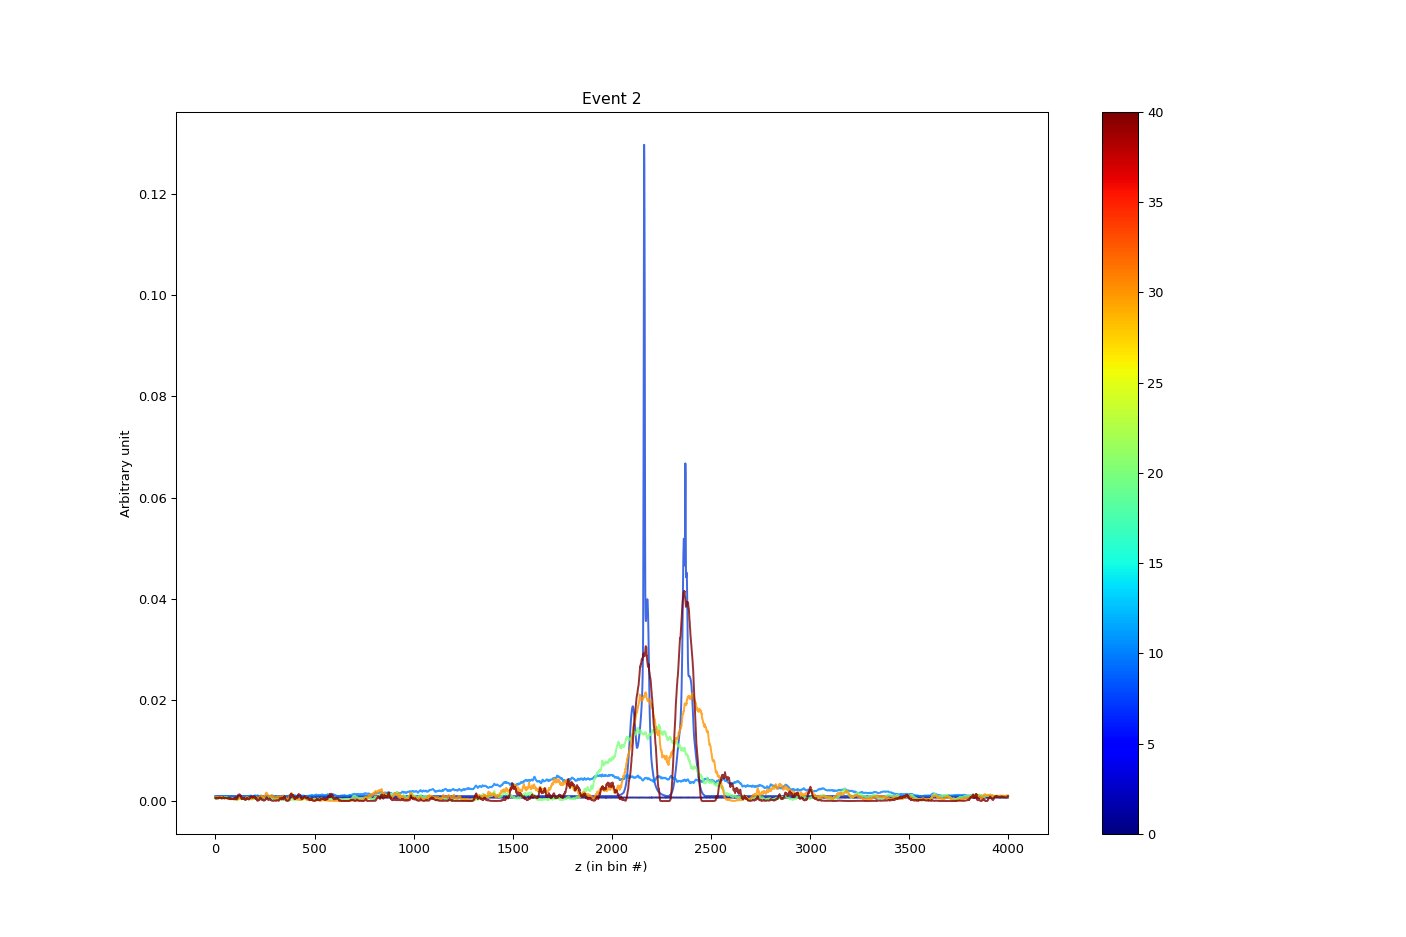

<IPython.core.display.Javascript object>


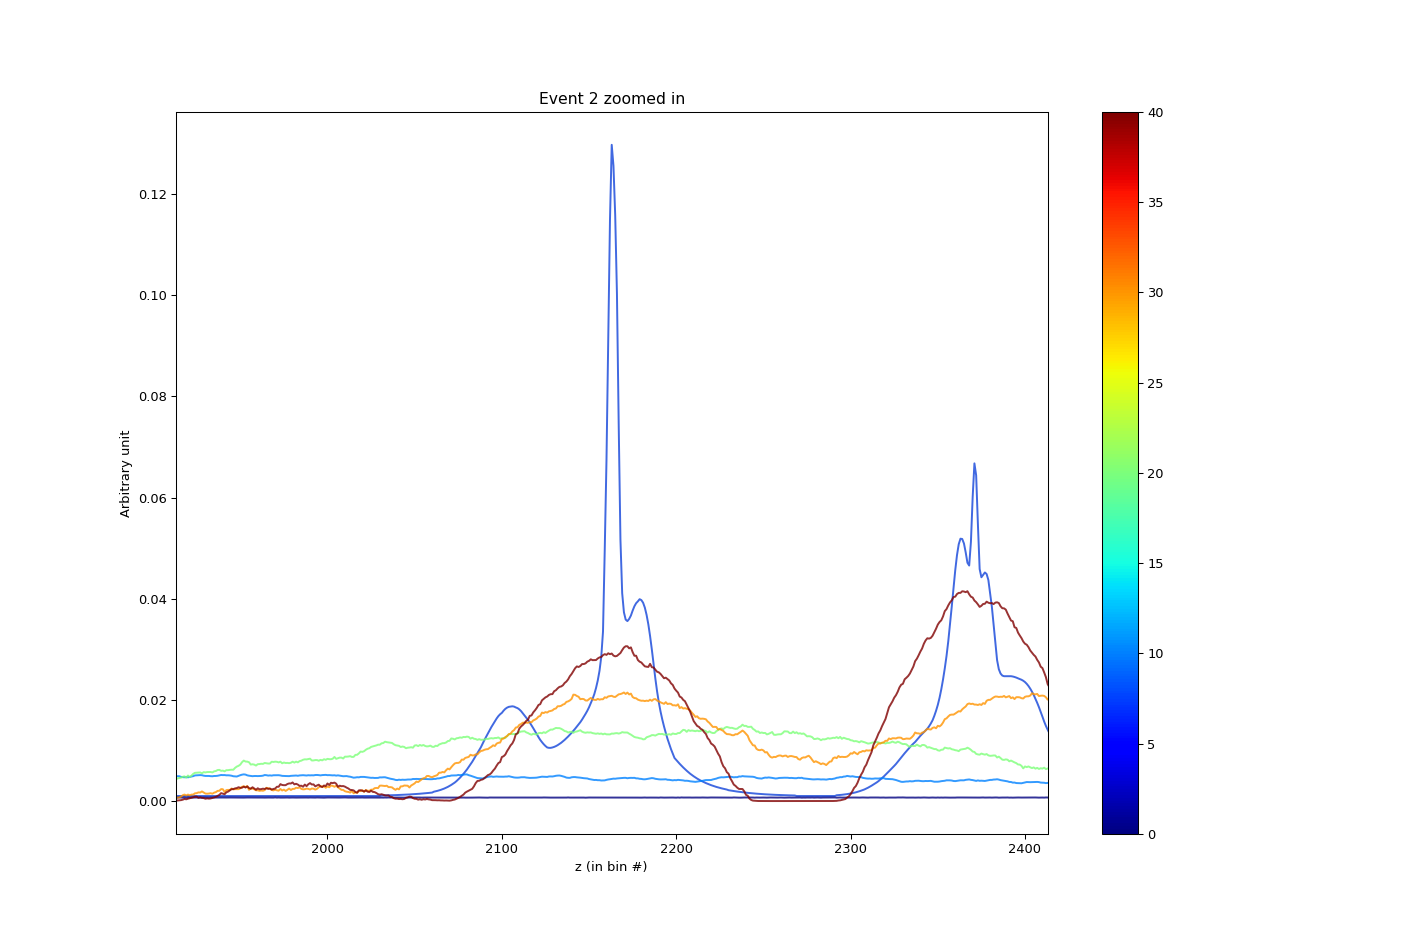

<IPython.core.display.Javascript object>


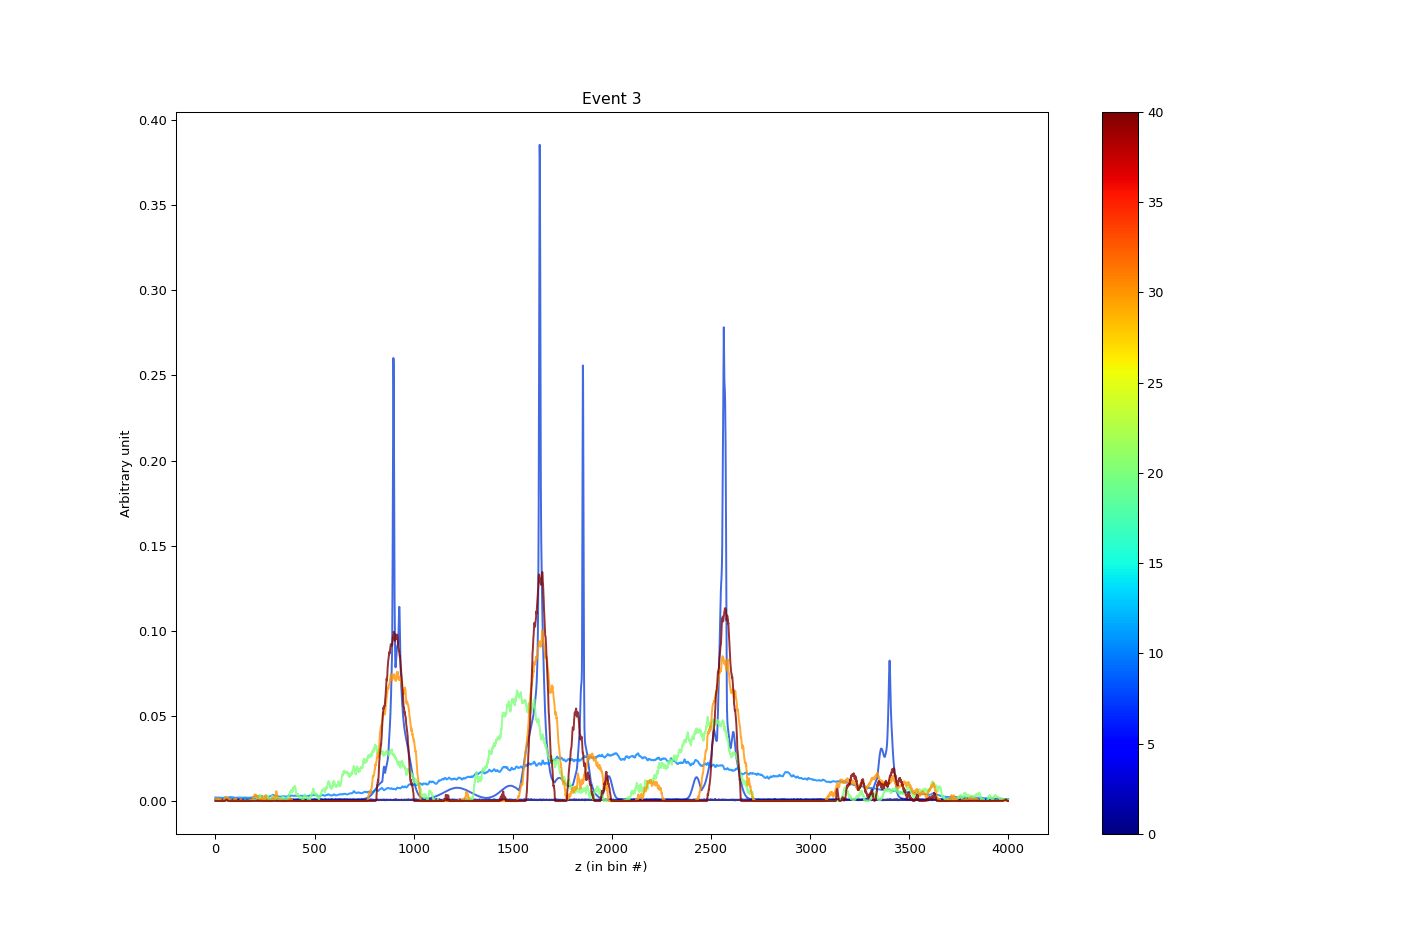

<IPython.core.display.Javascript object>


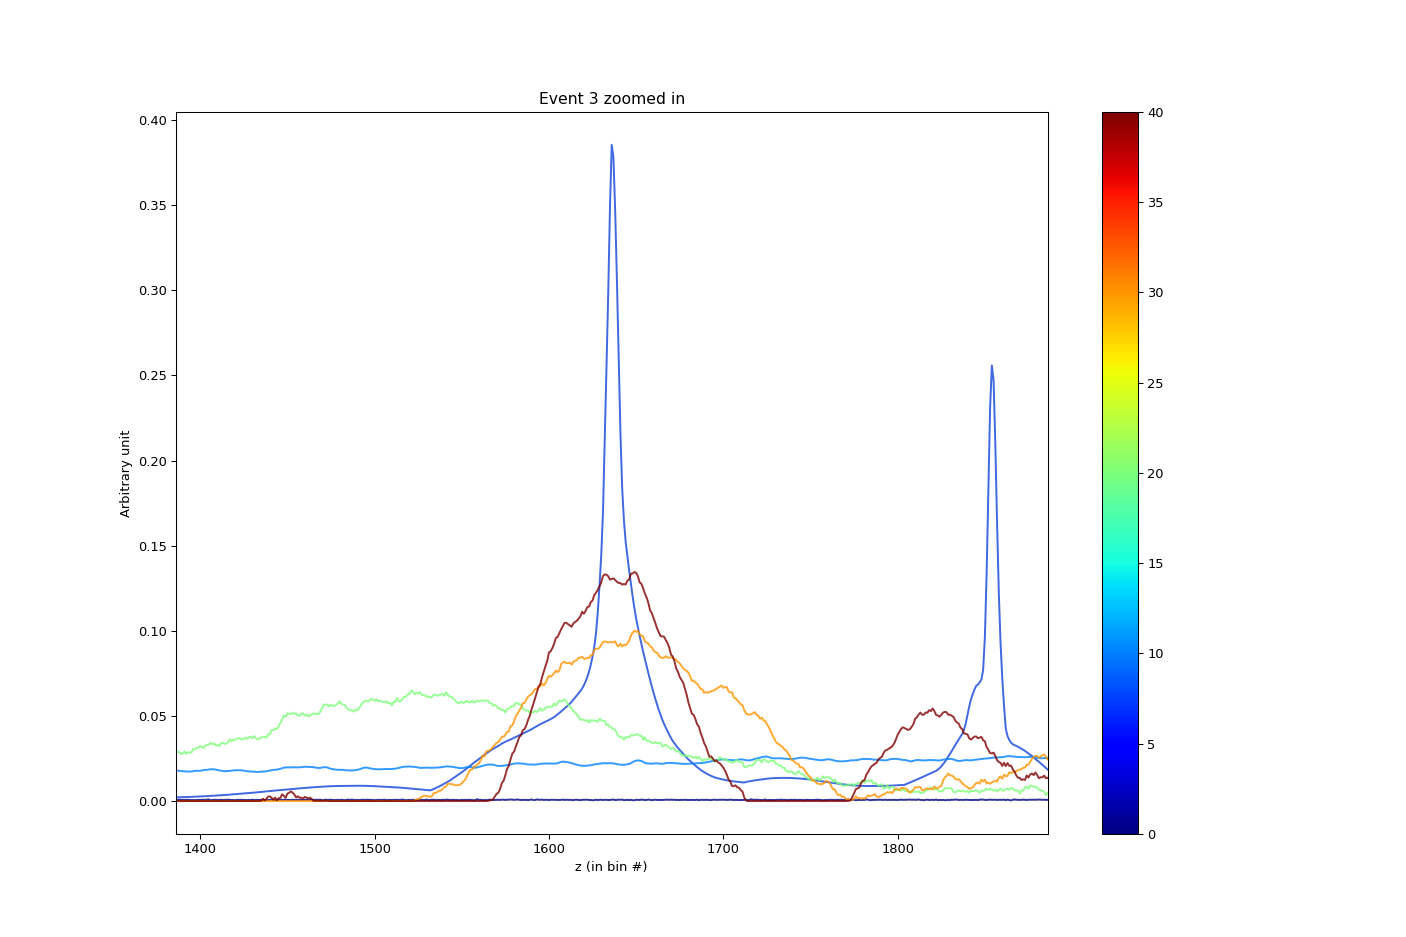

<IPython.core.display.Javascript object>


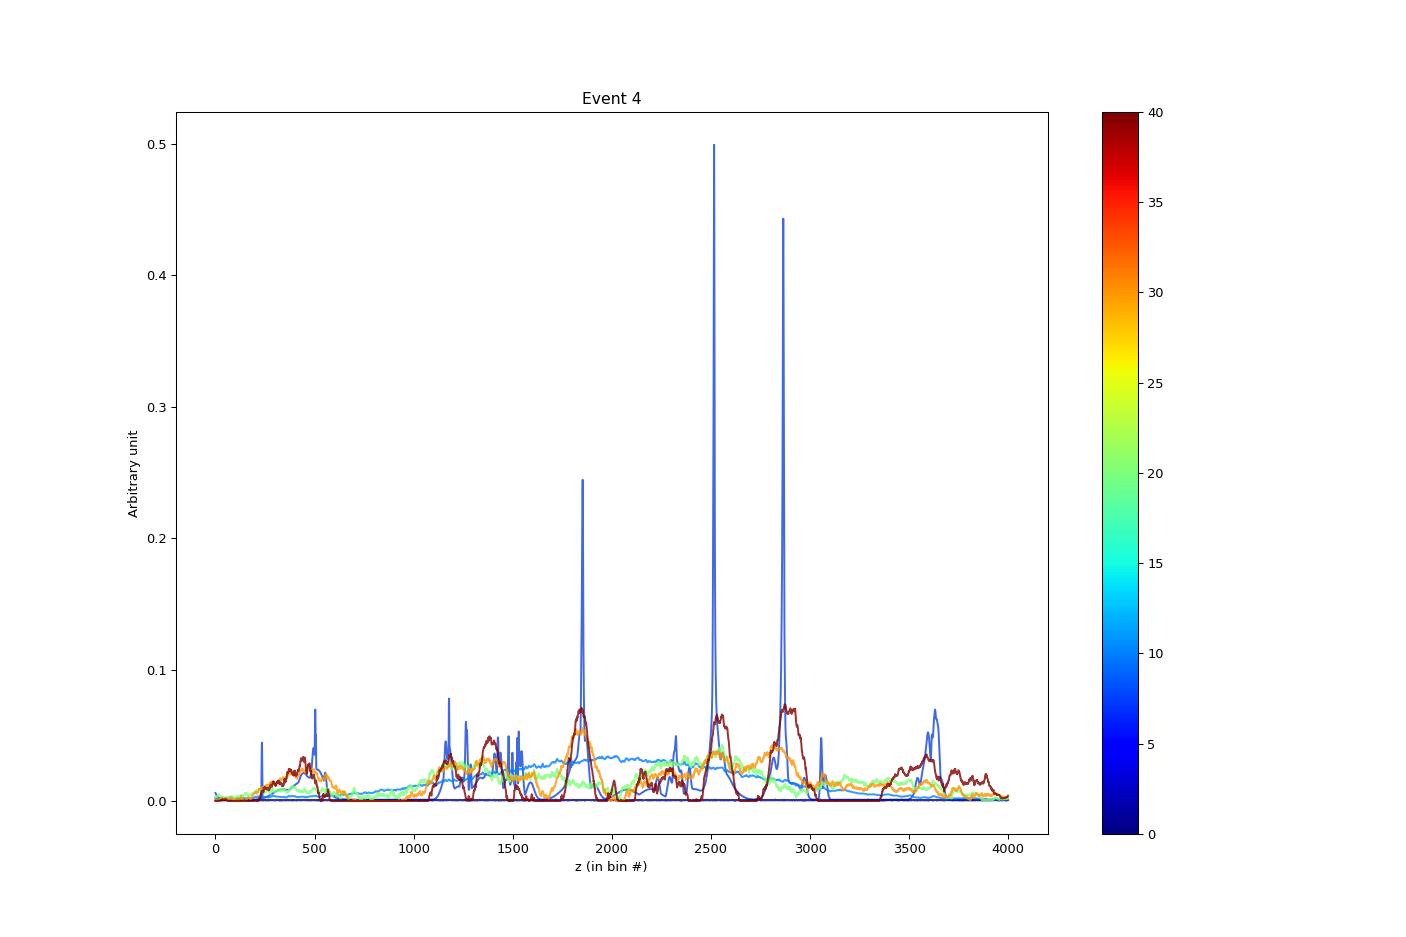

<IPython.core.display.Javascript object>


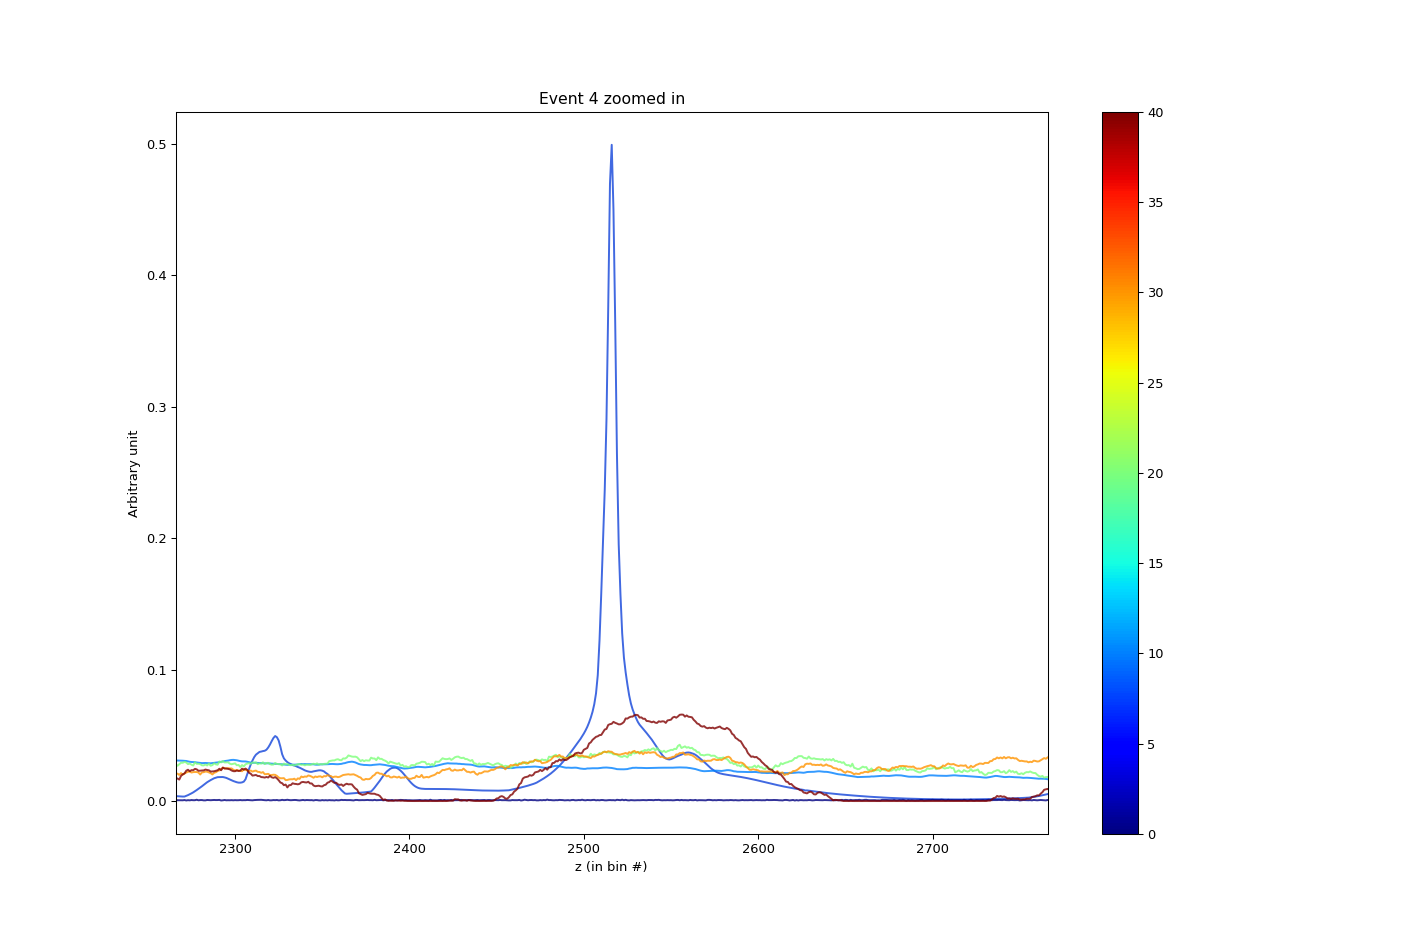

In [24]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)